In [1]:
from sys import version_info
import numpy as np
import cv2
#import imutils
from matplotlib import pyplot as plt
from scipy.signal import find_peaks_cwt, find_peaks
from skimage.data import page
from skimage.filters import threshold_sauvola
print('Python version: ' + str(version_info[:3]))
print('OpenCV version: ' + cv2.__version__)
def undesired_objects (image):
    image = image.astype('uint8')
    nb_components, output, stats, centroids = cv2.connectedComponentsWithStats(image, connectivity=4)
    sizes = stats[:, -1]

    max_label = 1
    max_size = sizes[1]
    for i in range(2, nb_components):
        if sizes[i] > max_size:
            max_label = i
            max_size = sizes[i]
            
    img2 = np.zeros(output.shape)
    img2[output == max_label] = 255
    cv2.imwrite("output_files/biggest_component.png", img2)
    return img2

def inverted(imagem):
    imagem = (255-imagem)
    return imagem
    
def imshow_components(labels):
    # Map component labels to hue val
    label_hue = np.uint8(179*labels/np.max(labels))
    blank_ch = 255*np.ones_like(label_hue)
    labeled_img = cv2.merge([label_hue, blank_ch, blank_ch])

    # cvt to BGR for display
    labeled_img = cv2.cvtColor(labeled_img, cv2.COLOR_HSV2BGR)

    # set bg label to black
    labeled_img[label_hue==0] = 0

    cv2.imwrite('output_files/connected_components.png', labeled_img)

Python version: (3, 5, 5)
OpenCV version: 3.4.2


In [122]:
#Read image, and perform binarization using Otsu algorithm
img = cv2.imread('input_files/test7.jpg')  #Afbeelding waar je alles op uitvoert
gray = cv2.cvtColor(img,cv2.COLOR_BGR2GRAY)
#Perform OTSU binarization
ret, thresh = cv2.threshold(gray,0,255,cv2.THRESH_BINARY_INV+cv2.THRESH_OTSU)
#Show  and save image
cv2.imwrite('output_files/otsu.png',thresh)
#Find connected components of image
output_components = cv2.connectedComponentsWithStats(cv2.bitwise_not(thresh))
# The first cell is the number of labels
num_labels = output_components[0]
# The second cell is the label matrix
labels = output_components[1]
# The third cell is the stat matrix
stats = output_components[2]
# The fourth cell is the centroid matrix
centroids = output_components[3]
#Show the components of the image
imshow_components(labels)

In [123]:
#Get the biggest components, the dead sea scroll.
largest_component = undesired_objects(cv2.bitwise_not(thresh))
#Convert to right type
largest_component = largest_component.astype('uint8')
#Save file for debugging purposes. 
cv2.imwrite('output_files/is_dit_het_nou.png', largest_component)

True

In [124]:
largest_component_copy = largest_component
contours, hierarchy = cv2.findContours(largest_component, cv2.RETR_EXTERNAL, cv2.CHAIN_APPROX_NONE)
bounding_boxes = [cv2.boundingRect(contour) for contour in contours]

print(bounding_boxes)
x = bounding_boxes[0][0]
y = bounding_boxes[0][1]
width = bounding_boxes[0][2]
height = bounding_boxes[0][3]
#Crop the image to get only the scroll
crop_img = largest_component_copy[y:y+height, x:x+width]
cv2.imwrite('output_files/crop.png', crop_img)
#Draw rectangle around the largest component to see what is being cropped. 
cv2.rectangle(largest_component_copy,(x,y),(x+width,y+height),(255,0,0),2)
cv2.imwrite('output_files/vierkant.png', largest_component_copy)

[(740, 279, 933, 1027)]


True

In [125]:
crop_img2 = img[y:y+height, x:x+width]


# noise removal
kernel = np.ones((3,3),np.uint8)
opening = cv2.morphologyEx(crop_img,cv2.MORPH_OPEN,kernel, iterations = 2)
#Save image for debugging
cv2.imwrite('output_files/opening.png',opening)
# sure background area
sure_bg = cv2.dilate(opening,kernel,iterations=3)
# Finding sure foreground area
dist_transform = cv2.distanceTransform(opening,cv2.DIST_L2,5)
ret, sure_fg = cv2.threshold(dist_transform,0.7*dist_transform.max(),255,0)
#Save image for debugging
cv2.imwrite('output_files/dist_transform.png',dist_transform)
# Finding unknown region
sure_fg = np.uint8(sure_fg)
unknown = cv2.subtract(sure_bg,sure_fg)

In [126]:
cv2.imwrite('output_files/fg.png',sure_fg)
cv2.imwrite('output_files/bg.png',sure_bg)
cv2.imwrite('output_files/unkown.png',unknown)

True

In [127]:
# Marker labelling
ret, markers = cv2.connectedComponents(sure_fg)
# Add one to all labels so that sure background is not 0, but 1
markers = markers+1
# Now, mark the region of unknown with zero
markers[unknown==255] = 0
cv2.imwrite('output_files/markers.png',markers)

True

In [128]:
#Perform watershed and save the result. 
markers = cv2.watershed(crop_img2,markers)
crop_img2[markers == -1] = [0,255,0]
cv2.imwrite('output_files/watershed_output.png',crop_img2)

True

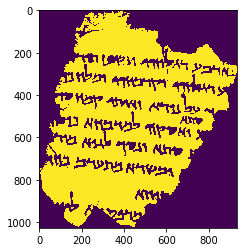

In [10]:
plt.imshow(opening)

In [120]:
def getHist(inputimg):    
    if np.amax(inputimg) == 255:
        binary_img = inputimg[inputimg > 0] = 1
    else:
        binary_img = inputimg    
    height, width = binary_img.shape
    hist = []
    for x in range(height):
        # find indexes of start and end of paper
        pixels = np.where(binary_img[x] == 1)
        if len(pixels[0])>0:
            rightp = pixels[0][-1]
            leftp = pixels[0][0]
            #calculate paper width
            paperw = rightp-leftp
            #sum number of white pixels
            rowsum = binary_img[x].sum()
            normsum = rowsum/paperw
            #if normsum > 1.1: normsum = 0
            hist.append(normsum)
        else:
            hist.append(0)
    return hist

i = 0
hists = []
for angle in np.arange(-45,50,5):
    rotated = imutils.rotate_bound(crop_img, angle)
    opening = cv2.morphologyEx(rotated,cv2.MORPH_OPEN,kernel, iterations = 2)
    hist = opening[opening > 0] = 1  
    hists.append(getHist(opening))
    i += 1
    
avg = 0
best_peaks = []
for j in range(i):
    hist = hists[j]
    #plt.bar(range(1,1+len(hist)),hist)
    plt.plot(range(1,1+len(hist)),hist)
    peaks, _ = find_peaks(hist, height = sum(hist)/len(hist), distance = len(hist)/10)
   # plt.plot(hist.index[peaks], hist.water_level[hist], 'ro', label = 'positive peaks')
    print(peaks)
   # print(hist[list(peaks)])
    peakplot = [hist[i] for i in peaks]
    plt.plot(peaks,peakplot,'ro')
    #print (peakplot)
    if np.mean(peaks) > avg :
        avg = np.mean(peaks)
        best_peaks = peaks
        index_angle = j

best_angle = -45+index_angle*5
print(best_peaks)
rotated = imutils.rotate_bound(crop_img,best_angle)
opening = cv2.morphologyEx(rotated,cv2.MORPH_OPEN,kernel, iterations = 2)

NameError: name 'imutils' is not defined

NameError: name 'best_peaks' is not defined

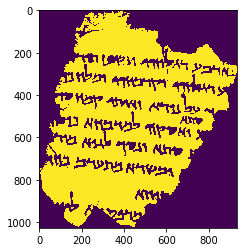

In [11]:
plt.imshow(opening)
plt.hlines(best_peaks,0,len(opening[0])-1,colors='w')

In [129]:
def getHist(inputimg, mask):    
    #inputimg = cv2.bitwise_not(inputimg)
    if np.amax(inputimg) == 255:
        binary_img = inputimg / 255
    else:
        binary_img = inputimg  
    height, width = binary_img.shape
    hist = []
    for x in range(height):
        # find indexes of start and end of paper
        pixels = np.where(mask[x] == 0)
        if len(pixels[0])>0:
            rightp = pixels[0][-1]
            leftp = pixels[0][0]
            #calculate paper width
            paperw = rightp-leftp
            #sum number of white pixels
            rowsum = binary_img[x].sum()
            normsum = rowsum/paperw
            #normsum = rowsum
            #if normsum > 1.1: normsum = 0
            hist.append(normsum)
        else:
            hist.append(0)
    return hist

def hole_removal (image, percentile):
    image = image.astype('uint8')
    nb_components, output, stats, centroids = cv2.connectedComponentsWithStats(image, connectivity=8)
    sizes = stats[:, -1]
    #Show components of the image
    imshow_components(output)
    #Calculate the threshold to remove holes
    sizes_copy = np.delete(sizes, np.argmax(sizes))
    avg = np.average(sizes_copy)
    #The x percentile is used as a threshold
    val = np.percentile(sizes_copy, percentile)
    var_threshold = val
    print(avg)
    print(val)
    #We also create an absolute threshold to not accidentally remove small characters
    abs_threshold = 1500
    #Calculate the pixel density for each component
    pixel_density = np.zeros(nb_components+1)
    for i in range(2, nb_components):
        #convert connected component to an image and get white pixel density
        img1 = np.zeros(output.shape)
        img1[output == i] = 255
        cv2.imwrite("output_files/biggest_componenttemp.png", img1)
        pixel_density[i] = pixel_density_connected_component(img1, image)
        #raw_input("Press Enter to continue...")
    
    #Calculate the desnity threshold with a percentile. 
    density_threshold = np.percentile(pixel_density, 25)
    #Create empty image, only add components smaller than the threshold
    img2 = np.zeros(output.shape)
    for i in range(2, nb_components):
        if sizes[i] <= var_threshold:
            img2[output == i] = 255
        elif sizes[i] <= abs_threshold:
            img2[output == i] = 255
        #elif sizes[i] > var_threshold:
         #   if pixel_density[i] <= density_threshold:
         #       img2[output == i] = 255
    return img2



def binarizeSlice(slice, folder, y):
    img = cv2.imread(slice)
    gray = cv2.cvtColor(img,cv2.COLOR_BGR2GRAY)
    ret, thresh = cv2.threshold(gray,0,255,cv2.THRESH_BINARY_INV+cv2.THRESH_OTSU)
    inv = cv2.bitwise_not(thresh)
    #hole_removed = hole_removal(cv2.bitwise_not(thresh), 99.4)
    cv2.imwrite(folder+'slice_binarize'+str(y)+'.png',inv)  
    
# slices papyrus in little papyri
def sliceImg(inputimg, slices, folder, original, mask):
    if np.amax(inputimg) == 1:
        paper = inputimg * 255
    else:
        paper = inputimg
    height, width = paper.shape
    lastslice = 0
    for x in range(height):
        if sum(paper[x]) > 0:
            lastslice = x
            break
    paper = cv2.bitwise_not(paper)
    mask = mask.astype('uint8')
    original = cv2.bitwise_and(original, original, mask=mask)
    for y in range(len(slices)):
        #check if slice is big enough
        #if slices[y]-lastslice > height/(len(slices)*4):
        #cv2.imwrite(folder+'slice'+str(y)+'.png',paper[lastslice:slices[y]])
        cv2.imwrite(folder+'slice'+str(y)+'.png',original[lastslice:slices[y]])        
        lastslice = slices[y]
        binarizeSlice(folder+'slice'+str(y)+'.png', folder, y)
    #cv2.imwrite(folder+'slice'+str(y+1)+'.png',original[lastslice:])  

def imshow_components2(labels):
    # Map component labels to hue val
    label_hue = np.uint8(179*labels/np.max(labels))
    blank_ch = 255*np.ones_like(label_hue)
    labeled_img = cv2.merge([label_hue, blank_ch, blank_ch])

    # cvt to BGR for display
    labeled_img = cv2.cvtColor(labeled_img, cv2.COLOR_HSV2BGR)

    # set bg label to black
    labeled_img[label_hue==0] = 0

    return labeled_img





def pixel_density_connected_component (connectedComponent, image):
    #Make sure image is of correct type
    connectedComponent = connectedComponent.astype('uint8')
    
    #Create bounding box around largest component with contours
    contours, hierarchy = cv2.findContours(connectedComponent, cv2.RETR_EXTERNAL, cv2.CHAIN_APPROX_NONE)
    bounding_boxes = [cv2.boundingRect(contour) for contour in contours]

    #Get the appropriate coordinates
    x = bounding_boxes[0][0]
    y = bounding_boxes[0][1]
    width = bounding_boxes[0][2]
    height = bounding_boxes[0][3]
    
    #Crop image to bounding box arround component
    crop_img = image[y:y+height, x:x+width]
    cv2.imwrite('output_files/cropped_component.png', crop_img)
    #Calculate density of the this newly create image of component
    area = float(crop_img.shape[0]*crop_img.shape[1])
    whitePixels = float(np.sum(crop_img == 255))
    density = whitePixels/area
    #print("whitePixels: {}".format(whitePixels))
    #print("area: {}".format(area))
    #print("density: {}".format(density))

    return density


def img_fill(im_th):  # n = binary image threshold
    # Copy the thresholded image.
    im_floodfill = im_th.copy()

    # Mask used to flood filling.
    # Notice the size needs to be 2 pixels than the image.
    h, w = im_th.shape[:2]
    mask = np.zeros((h + 2, w + 2), np.uint8)

    # Floodfill from point (0, 0)
    cv2.floodFill(im_floodfill, mask, (0, 0), 255);

    # Invert floodfilled image
    im_floodfill_inv = cv2.bitwise_not(im_floodfill)

    # Combine the two images to get the foreground.
    fill_image = im_th | im_floodfill_inv

    return fill_image 


In [130]:
#(NOT USED ATM) Appends all images from one folder in a list
import glob
#import cv2
def readFolder(path):
    extension = 'jpg'
    image_list = []
    if len(glob.glob(path+'*.'+extension)) > 0:
        for filename in glob.glob(path+'*.'+extension):
            image_list.append(cv2.imread(filename))
    else:
        print('ERROR: There were no {} files found in folder {}'.format(extension, path))
    return image_list

imlist = readFolder('input_files/image-data/')

In [131]:
import glob
import os
# Processes all images in a folder and saves them to separate folders
def processImages(path):
    extension = 'jpg'
    if len(glob.glob(path+'*.'+extension)) > 0:
        print('Started with processing of {} files'.format(len(glob.glob(path+'*.'+extension))))
        for file in glob.glob(path+'*.'+extension):
            newfolder = 'output_files/image-data/'+file.rsplit('.',1)[0].rsplit('/',1)[1]+'/'
            print('Processing ' + newfolder.rsplit('/',1)[0].rsplit('/',1)[1])
            if not os.path.exists(newfolder):
                os.makedirs(newfolder)
            
            #Read image, and perform binarization using Otsu algorithm
            img = cv2.imread(file)
            cv2.imwrite(newfolder+'original.png',img)
            
            gray = cv2.cvtColor(img,cv2.COLOR_BGR2GRAY)
            #Perform OTSU binarization
            ret, thresh = cv2.threshold(gray,0,255,cv2.THRESH_BINARY_INV+cv2.THRESH_OTSU)
            #Show  and save image
            cv2.imwrite(newfolder+'otsu.png',thresh)
            
            #Find connected components of image
            output_components = cv2.connectedComponentsWithStats(cv2.bitwise_not(thresh))
            # The first cell is the number of labels
            num_labels = output_components[0]
            # The second cell is the label matrix
            labels = output_components[1]
            # The third cell is the stat matrix
            stats = output_components[2]
            # The fourth cell is the centroid matrix
            centroids = output_components[3]
            #print the components of the image
            labeled_img = imshow_components2(labels)
            cv2.imwrite(newfolder+'connected_components.png', labeled_img)
            
            #Get the biggest components, the dead sea scroll.
            largest_component = undesired_objects(cv2.bitwise_not(thresh))
            #Convert to right type
            largest_component = largest_component.astype('uint8')
            #Save file for debugging purposes.
            cv2.imwrite(newfolder+'is_dit_het_nou.png', largest_component)
            
            #Lex 09-06
            crop_img = largest_component
            ###################################################################
            kernel2 = np.array([[1,1,1],[1,1,1],[1,1,1]])
            kernel3 = np.array([[1,1],[1,1]])
            dilated_img = cv2.dilate(crop_img,kernel2,iterations = 2)
            cv2.imwrite(newfolder+'dilated.png', dilated_img)

            #Get the countours of the scroll
            contours, hierarchy = cv2.findContours(dilated_img, cv2.RETR_EXTERNAL, cv2.CHAIN_APPROX_NONE)
            img2 = np.zeros(crop_img.shape)
            img_contour = cv2.drawContours(img2, contours, -1, 255, -1)

            #dilate and erode to fill up the edges of the scroll.
            img_contour = cv2.dilate(img_contour,kernel2,iterations = 6)
            img_contour = cv2.erode(img_contour,kernel2,iterations = 10)
            cv2.imwrite(newfolder+'contours.png', img_contour)

            #Convert the shape of the scroll to binarized image and invert.  
            ret, mask = cv2.threshold(img_contour, 127, 255, cv2.THRESH_BINARY)
            mask = mask.astype('uint8')
            mask = cv2.bitwise_not(mask)
            cv2.imwrite(newfolder+'mask.png', mask)

            #Add the mask to the original image to delete background. 
            added = crop_img + mask
            #added = cv2.morphologyEx(added, cv2.MORPH_CLOSE, kernel3, iterations = 3)
            #added = cv2.morphologyEx(added, cv2.MORPH_CLOSE, kernel2, iterations = 1)
            cv2.imwrite(newfolder+'added.png', added)

            #Get rid of noise, especially at the edges
            added = cv2.morphologyEx(added, cv2.MORPH_CLOSE, kernel2, iterations = 1)

            #To debug: show largest connected component of the result. 
            mask = undesired_objects(cv2.bitwise_not(added))
            cv2.imwrite(newfolder+'added_inv.png', cv2.bitwise_not(added))

            output_hole_removal = hole_removal(cv2.bitwise_not(added), 99.4)
            output_hole_removal = output_hole_removal.astype('uint8')
            cv2.imwrite(newfolder+'holes_removed.png', cv2.bitwise_not(output_hole_removal))
            
            
            # noise removal
            kernel = np.ones((3,3),np.uint8)
            opening = cv2.morphologyEx(largest_component,cv2.MORPH_OPEN,kernel, iterations = 2)
            #Save image for debugging
            cv2.imwrite(newfolder+'opening.png',opening)
            
            #hist = getHist(opening)
            hist = getHist(output_hole_removal, img_contour)
            #peaks, _ = find_peaks(hist, height = sum(hist)/len(hist), distance = len(hist)/20)
            #peaks, _ = find_peaks(hist, distance = len(hist)/40, height = max(hist)/2)
            #widths=np.arange(1)
            #peaks = find_peaks_cwt(hist, widths)
            peaks, _ = find_peaks(hist, width=5, distance = len(hist)/40, height = max(hist)/10)
            peaks2 = []
            for x in range(len(peaks)-1):
                peaks2.append(int((peaks[x]+peaks[x+1])/2))
            sliceImg(output_hole_removal,peaks2,newfolder,output_hole_removal,img_contour)
            peakplot = [hist[i] for i in peaks]
            plt.plot(range(1,1+len(hist)),hist)
            plt.plot(peaks,peakplot,'ro')
            plt.savefig(newfolder+'histogram.png',dpi=300)
            plt.close()
            
            #plt.imshow(output_hole_removal)
            plt.imshow(cv2.bitwise_and(img, img, mask=img_contour.astype('uint8')))
            plt.hlines(peaks2,0,len(output_hole_removal[0])-1,colors='w')
            plt.savefig(newfolder+'holes_removed_lines.png',dpi=300)
            plt.close()
            
        print('FINISHED! Files saved in folders in the {} folder'.format(path.rsplit('/',1)[0].rsplit('/',1)[1]))
    else:
        print('ERROR: There were no {} files found in folder {}'.format(extension, path))


processImages('input_files/image-data/')

Started with processing of 20 files
Processing P123-Fg002-R-C01-R01-fused
391.3893967093236
2539.6880000000006
Processing P583-Fg002-R-C01-R01-fused
735.1276595744681
4348.614000000011
Processing P583-Fg006-R-C01-R01-fused
957.4468085106383
5693.812000000013
Processing P106-Fg002-R-C01-R01-fused
323.8491620111732
1802.2900000000002


KeyboardInterrupt: 